# PPG Peak Detection without Ground‑Truth Labels
**30‑s window, pseudo‑label distillation approach**

This notebook demonstrates how to build a PyTorch pipeline that loads raw PPG recordings from an HDF5 file, generates heuristic peak labels on‑the‑fly, and trains a small 1‑D U‑Net to predict a peak‑probability map.

*Assumptions*
*  HDF5 file created from the .mat dataset (one group per recording). 
*  Each group contains a `ppg` dataset (float32) and attributes `fs`, `subj_id`, `af_status`.

Created: 2025-04-18

https://iopscience.iop.org/article/10.1088/1361-6579/adb89e

In [1]:

# # If you need any extra packages:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install h5py scipy tqdm
# !pip install torchinfo

# !pip install heartpy

In [2]:
from torchinfo import summary
import h5py, math, random, os, sys, gc
import numpy as np
import scipy.signal as signal
import scipy.ndimage as ndi
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
import heartpy as hp

import torch, os
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
# %matplotlib
# %matplotlib notebook

device = 'cuda' if torch.cuda.is_available() else 'mps'
print('Device:', device)
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"    # avoid crashes on odd ops
torch.mps.empty_cache()                            # call between val runs


Device: mps


In [3]:
# t1 = h5py.File("downloaded_files/length_full/train_ds.h5", 'r', swmr=True)
# idxs = list(t1.keys())
# t1[idxs[0]]['ppg'][:].astype('float32')
# t1[idxs[0]].attrs.get('af_status')

In [4]:

# ----------------------------- configuration -----------------------------
FOLDER_PATH = 'length_full'
H5_PATH = os.path.join('downloaded_files',FOLDER_PATH,'mimic_non_af_data.h5')  # update if your file lives elsewhere
WIN_SEC = 30                      # window length in seconds
FS_ORIGINAL = 125
DEC_FACTOR = 6
FS = round(FS_ORIGINAL/DEC_FACTOR,2)                  # Hz (dataset‑wide constant)
print(FS)
WIN_LEN = int(round(WIN_SEC * FS))            # 3_750 samples
BATCH   = 32
EPOCHS  = 200                       # demo; increase to 30+ for real training

VAR_MULT=500


20.83


In [5]:
# from mmpvd2 import MSPTDFastV2BeatDetector

# # ----------------------------- helpers -----------------------------------
# def bandpass(x, fs=FS, low=0.5, high=8.):
#     b, a = signal.butter(2, [low/fs*2, high/fs*2], btype='band')
#     return signal.filtfilt(b, a, x)

# def pseudo_peak_vector(seg, fs=FS):
#     """Return soft (Gaussian) peak map for a 1‑D segment."""
#     detector = MSPTDFastV2BeatDetector(
#         use_reduced_lms_scales=True,
#         do_ds=True,
#         ds_freq=20.83,
#         optimisation=True
#     )        # OO style
#     _, locs = detector.detect(seg, fs)

#     y = np.zeros_like(seg, dtype='float32')
#     y[locs] = 1.
#     # y = ndi.gaussian_filter1d(y, sigma=1, mode='constant')
#     return y

# def find_sliding_window(input_size, target_windows, overlap):
#     """
#     Finds window_size, hop_size, and number of windows closest to target_windows.

#     If `overlap == 0` and `input_size` divides evenly by `target_windows`, returns
#     the exact division `(input_size//target_windows, input_size//target_windows, target_windows)`.

#     Args:
#         input_size (int): Total number of samples in your signal.
#         target_windows (int): Desired number of windows.
#         overlap (int): Number of samples overlapping between consecutive windows.

#     Returns:
#         tuple: (window_size, hop_size, num_windows), or None if no valid configuration.
#     """
#     # Exact division when no overlap
#     if overlap == 0 and input_size % target_windows == 0:
#         win = input_size // target_windows
#         return (win, win, target_windows)

#     best_config = None
#     best_diff = float('inf')

#     # Search for best approximate configuration
#     for window_size in range(overlap + 1, input_size + 1):
#         hop_size = window_size - overlap
#         if hop_size <= 0:
#             continue

#         num_windows = (input_size - overlap) // hop_size
#         if num_windows < 1:
#             continue

#         diff = abs(num_windows - target_windows)
#         divides_evenly = (input_size - overlap) % hop_size == 0
#         best_divides = False
#         if best_config is not None:
#             best_divides = ((input_size - overlap) % best_config[1] == 0)

#         # Prefer smaller diff, then even division
#         if diff < best_diff or (diff == best_diff and divides_evenly and not best_divides):
#             best_diff = diff
#             best_config = (window_size, hop_size, num_windows)

#     return best_config


# def scale_signal(input_vector: torch.Tensor,
#                  config: tuple,
#                  window_fn=None,
#                  method: str = 'norm') -> torch.Tensor:
#     """
#     Applies standardization or normalization over sliding windows defined by config,
#     and reconstructs the full signal via overlap-add.

#     Args:
#         input_vector (torch.Tensor): 1D tensor of shape (N,).
#         config (tuple): (window_size, hop_size, num_windows).
#         window_fn (callable, optional): fn(length) -> torch.Tensor of weights.
#                                          Defaults to uniform weights.
#         method (str): 'standard' for z-score, 'norm' for min-max then zero-mean.

#     Returns:
#         torch.Tensor: standardized tensor of same shape.
#     """
#     device = input_vector.device
#     dtype = input_vector.dtype
#     input_size = input_vector.size(0)
#     window_size, hop_size, _ = config

#     if window_fn is None:
#         window_fn = lambda n: torch.ones(n, device=device, dtype=dtype)

#     out = torch.zeros(input_size, device=device, dtype=dtype)
#     weights = torch.zeros(input_size, device=device, dtype=dtype)

#     for start in range(0, input_size, hop_size):
#         end = min(start + window_size, input_size)
#         segment = input_vector[start:end]

#         if method == 'standard':
#             mu = segment.mean()
#             sigma = segment.std(unbiased=False)
#             if sigma == 0:
#                 z = torch.zeros_like(segment)
#             else:
#                 z = (segment - mu) / sigma

#         elif method == 'norm':
#             min_val = segment.min()
#             max_val = segment.max()
#             denom = max_val - min_val
#             if denom == 0:
#                 z = torch.zeros_like(segment)
#             else:
#                 z = (segment - min_val) / denom
#                 z = z - z.mean()
#         else:
#             raise ValueError(f"Unknown method '{method}'")

#         w = window_fn(end - start)
#         if not torch.is_tensor(w):
#             w = torch.tensor(w, device=device, dtype=dtype)

#         out[start:end] += z * w
#         weights[start:end] += w

#         if end == input_size:
#             break

#     mask = weights > 0
#     out[mask] = out[mask] / weights[mask]
#     return out


In [6]:

# class PPGWindow(Dataset):
#     def __init__(self, h5_path, win_len=WIN_LEN, transform=True,var_mult=1000,best_config=(100, 75, 8),scale_type="standard"):
#         self.h5 = h5py.File(h5_path, 'r', swmr=True)
#         # self.ids = list(self.h5.keys())
#         self.ids = [gid for gid in self.h5.keys() if 'ppg' in self.h5[gid]]
#         self.win = win_len
#         self.transform = transform
#         self.var_mult = var_mult
#         self.best_config = best_config
#         self.scale_type = scale_type

#         # Precompute valid window-start indices for each record
#         self.valid_starts = {}
#         for gid in self.ids:
#             arr = self.h5[gid]['ppg'][:].astype('float32')
#             # pad wrap if too short
#             if len(arr) < self.win + 1:
#                 arr = np.pad(arr, (0, self.win + 1 - len(arr)), mode='wrap')

#             ends = len(arr) - self.win + 1
#             # vectorized check: slide a window of length win
#             # create strided view for mean and std
#             # fallback simple loop if memory is a concern
#             starts = []
#             for s in range(0, ends):
#                 seg = arr[s:s+self.win]
#                 if seg.any() and seg.std() != 0:
#                     starts.append(s)
#             self.valid_starts[gid] = np.array(starts, dtype=np.int64)
            
#     def __len__(self):
#         # virtually infinite; adjust if you want a fixed number
#         return len(self.ids) * self.var_mult

#     def __getitem__(self, idx):
#         # select record and then a valid start index
#         gid = self.ids[idx % len(self.ids)]
#         starts = self.valid_starts[gid]
#         if len(starts) == 0:
#             # no valid windows: fallback to uniform sampling
#             x = self.h5[gid]['ppg'][:].astype('float32')
#             if len(x) < self.win + 1:
#                 x = np.pad(x, (0, self.win+1-len(x)), mode='wrap')
#             s = 0
#         else:
#             s = int(np.random.choice(starts))
#             x = self.h5[gid]['ppg'][:].astype('float32')
#             if len(x) < self.win + 1:
#                 x = np.pad(x, (0, self.win+1-len(x)), mode='wrap')

#         seg_np = x[s:s+self.win]

#         seg = torch.from_numpy(seg_np)
#         seg = scale_signal(seg, self.best_config, method= self.scale_type).float()

#         y_np = pseudo_peak_vector(seg.cpu().numpy())    # convert back to numpy
#         y = torch.from_numpy(y_np).float()
#         return (seg.unsqueeze(0), y, torch.from_numpy(seg_np).unsqueeze(0).float(),)


In [7]:
from PPGWindowModel import PPGWindow
from utils import *
TRAIN_PATH = f"downloaded_files/{FOLDER_PATH}/train_ds.h5"


best_config = find_sliding_window(WIN_LEN,target_windows = 5, overlap=25)
scale_type = "norm"
train_ds = PPGWindow(TRAIN_PATH,best_config=best_config,scale_type=scale_type)

from torch.utils.data import random_split

VAL_FRAC = 0.20               # 10 % of the *virtual* samples
n_total  = len(train_ds)
n_val    = int(n_total * VAL_FRAC)
n_train  = n_total - n_val

train_ds, val_ds = random_split(
    train_ds,
    lengths=[n_train, n_val],
    generator=torch.Generator().manual_seed(42)   # reproducible
)

train_loader = DataLoader(train_ds, batch_size=BATCH,
                          shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH,
                          shuffle=True, num_workers=0, pin_memory=False)

print('Dataset ready. Example batch shapes:')
x, y,_,_= next(iter(train_loader))
print(x.shape, y.shape)   # (B, 1, 3750) (B, 3750)



Dataset ready. Example batch shapes:
torch.Size([32, 1, 625]) torch.Size([32, 625])


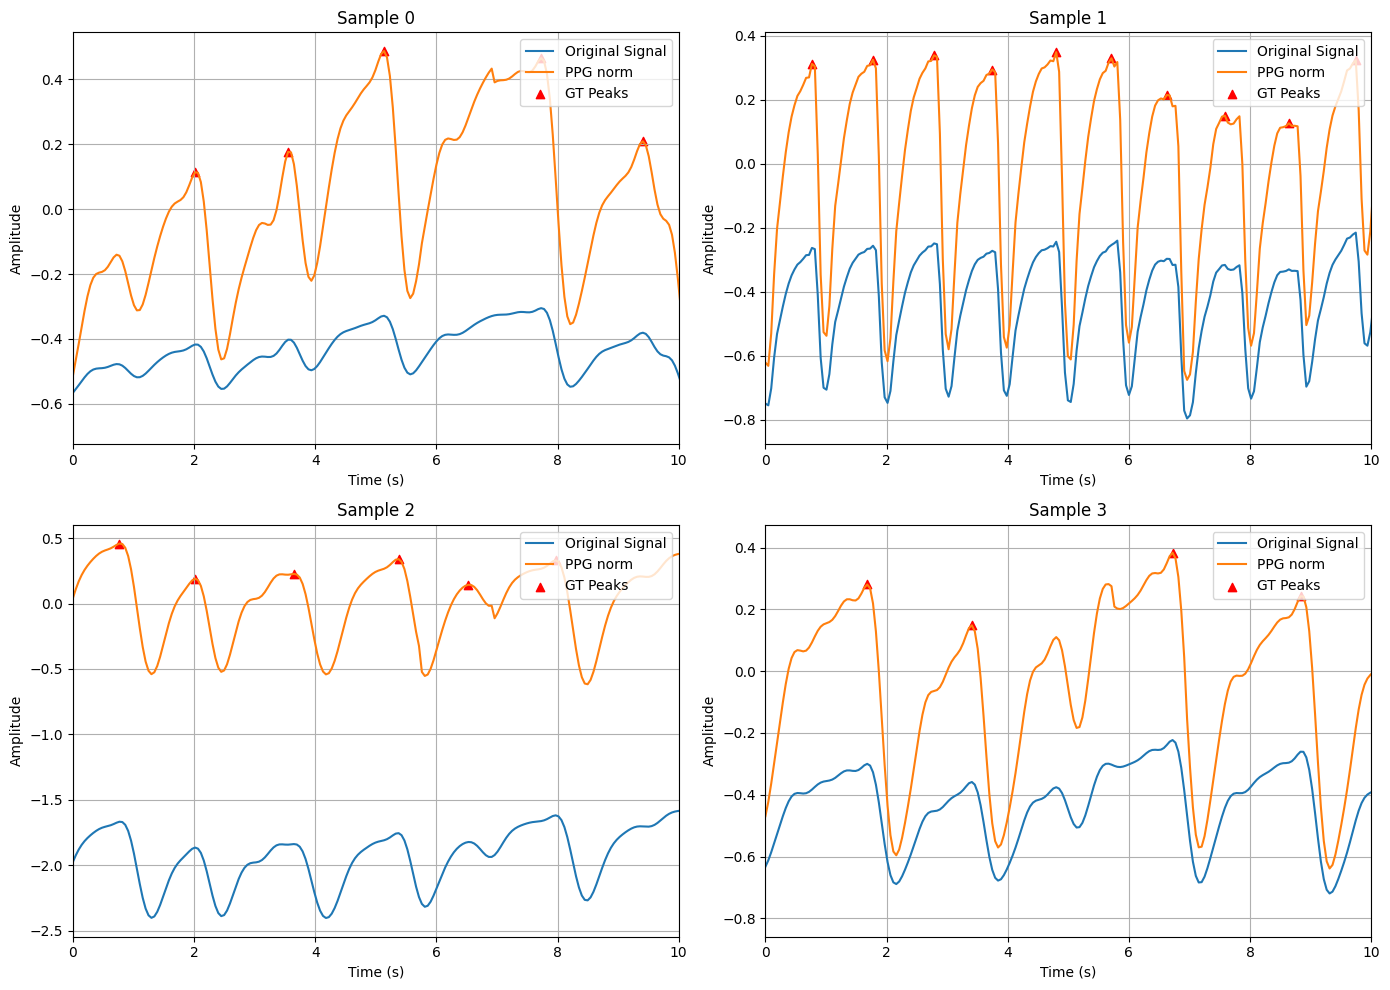

In [8]:
B, _, L = x.shape

# How many to plot
n_plot = min(4, B)
cols   = math.ceil(math.sqrt(n_plot))
rows   = math.ceil(n_plot / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*5), squeeze=False)

for i in range(n_plot):
    x, y,original_signal,_ = next(iter(train_loader))
    ax = axes[i//cols][i%cols]
    seg = scale_signal(x[0,0], best_config,method = scale_type)

    # call your function instead of hp.process
    y = pseudo_peak_vector(seg, fs=FS)
    peaks = np.nonzero(y > 0)[0]
    t = np.arange(len(seg)) / FS
    input_signal = original_signal[0,0]*-1
    seg *= -1


    ax.plot(t,original_signal[0,0]*-1,label='Original Signal')
    ax.plot(t, seg, label=f'PPG {scale_type}')
    ax.scatter(t[peaks], seg[peaks], c='r', marker='^', label='GT Peaks')
    ax.set_title(f'Sample {i}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='upper right')
    ax.grid()
    ax.set_xlim(0,10)

plt.tight_layout()
plt.show()

In [9]:
class EarlyStoppingBasic:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def step(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

In [10]:

# # ----------------------------- model -------------------------------------
# class ConvBlock(nn.Module):
#     def __init__(self, cin, cout, k=9, s=1):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Conv1d(cin, cout, k, stride=s, padding=k//2),
#             nn.BatchNorm1d(cout),
#             nn.ReLU(inplace=True),
#             nn.Conv1d(cout, cout, k, stride=1, padding=k//2),
#             nn.BatchNorm1d(cout),
#             nn.ReLU(inplace=True),
#         )
#     def forward(self, x): return self.net(x)

# class UNet1D(nn.Module):
#     def __init__(self, cin=1, base=16, depth=4):
#         super().__init__()
#         downs, ups, skips = [], [], []
#         c = cin
#         for d in range(depth):
#             downs.append(ConvBlock(c, base*(2**d), k=9))
#             c = base*(2**d)
#         self.downs = nn.ModuleList(downs)

#         # ── ❶ bridge: keep the same #channels, NOT double them  ────────────
#         self.bridge = ConvBlock(c, c, k=9)

#         # ── decoder   (one up‑conv + cat + convblock at each scale) ───────
#         for d in reversed(range(depth-1)):
#             ups.append(nn.ConvTranspose1d(c, c//2, 4, stride=2, padding=1))
#             ups.append(ConvBlock(c + c//2, c//2, k=9))
#             c = c // 2
#         self.ups = nn.ModuleList(ups)

#         self.head = nn.Conv1d(base, 1, 1)

#     def forward(self, x):
#         orig_len = x.shape[-1]                # ← ① remember 3 750
#         skips = []
#         for down in self.downs:
#             x = down(x)
#             skips.append(x)
#             x = nn.functional.avg_pool1d(x, 2)

#         x = self.bridge(x)

#         for i in range(0, len(self.ups), 2):
#             x = self.ups[i](x)       # up‑conv
#             skip = skips[-(i//2 + 1)]
#             if x.shape[-1] != skip.shape[-1]:
#                 diff = skip.shape[-1] - x.shape[-1]
#                 x = nn.functional.pad(x, (0, diff))
#             x = torch.cat([x, skip], dim=1)
#             x = self.ups[i+1](x)     # conv block

#         if x.shape[-1] != orig_len:
#             x = nn.functional.interpolate(x, size=orig_len,mode='linear', align_corners=False)
#         return self.head(x).squeeze(1)  # (B, 3750)

In [12]:
from unet1d import UNet1D

LEARNING_RATE = 3e-5;
model = UNet1D().to(device)
print(summary(model, input_size=(1,1, WIN_LEN)))

model = UNet1D().to(device)

optim = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# 1) Gather all labels from your training set (flattened)
all_labels = []
for _, yb,_, _ in train_loader:
    all_labels.append(yb.cpu().numpy().ravel())
all_labels = np.concatenate(all_labels)   # shape (N_total,)

# 2) Count zeros vs. ones
neg = (all_labels == 0).sum()
pos = (all_labels == 1).sum()

# 3) Build your pos_weight from that ratio
pos_weight = torch.tensor([neg/pos], dtype=torch.float32, device=device)

# 4) Create your loss once, using that pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([ len(zeros)/len(ones) ]).to(device))

scaler = torch.amp.GradScaler(enabled=False)       # autocast handles bfloat16

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,'min',factor=0.1,       # drop LR to 10%
    patience=3,       # after 3 epochs of no val_loss improvement
    threshold=1e-3,   # require 0.1% improvement to count
    threshold_mode='rel',
    verbose=True      # print a message when it happens)
)
early_stopper = EarlyStoppingBasic(patience=5, min_delta=1e-3)


Layer (type:depth-idx)                   Output Shape              Param #
UNet1D                                   [1, 625]                  --
├─ModuleList: 1-1                        --                        --
│    └─ConvBlock: 2-1                    [1, 16, 625]              --
│    │    └─Sequential: 3-1              [1, 16, 625]              2,544
│    └─ConvBlock: 2-2                    [1, 32, 312]              --
│    │    └─Sequential: 3-2              [1, 32, 312]              14,016
│    └─ConvBlock: 2-3                    [1, 64, 156]              --
│    │    └─Sequential: 3-3              [1, 64, 156]              55,680
│    └─ConvBlock: 2-4                    [1, 128, 78]              --
│    │    └─Sequential: 3-4              [1, 128, 78]              221,952
├─ConvBlock: 1-2                         [1, 128, 39]              --
│    └─Sequential: 2-5                   [1, 128, 39]              --
│    │    └─Conv1d: 3-5                  [1, 128, 39]              14

/Users/shayanriyaz/miniconda3/envs/AF_DETECTION/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
all_train_loss = []
all_val_loss = []
# ----------------------------- training ----------------------------------
for epoch in range(EPOCHS):
    model.train();
    cumulative_train_loss = 0
    for xb, yb,_,_ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}'):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True) 

        optim.zero_grad(set_to_none=True) 
        with torch.autocast("mps", dtype=torch.bfloat16):
            logits = model(xb).float()                 # autocast returns bf16
            train_loss   = criterion(logits, yb)

        if torch.isnan(train_loss): raise ValueError('NaN loss')
        
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optim.step()
        optim.zero_grad(set_to_none=True)
        cumulative_train_loss += train_loss.item() * xb.size(0)

    mean_train = cumulative_train_loss / (len(train_loader.dataset))
    all_train_loss.append(mean_train)

    # ───────────────── validation ─────────────────────────────────────
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb,_,_ in tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS}'):
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            with torch.autocast(device, dtype=torch.bfloat16):
                logits = model(xb).float()
                validation_loss   = criterion(logits, yb)
            if torch.isnan(validation_loss): raise ValueError('NaN loss')
            cumulative_val_loss += validation_loss.item() * xb.size(0)

    mean_val = val_loss / (len(val_loader.dataset))
    all_val_loss.append(mean_val)

    # ───────────────── bookkeeping ────────────────────────────────────
    scheduler.step(mean_val)         # if ReduceLROnPlateau
    print("lr=", optim.param_groups[0]['lr'])
    stop = early_stopper.step(mean_val)

    print(f"Epoch {epoch+1:02d}  "
          f"train={mean_train:.4f}  val={mean_val:.4f}  "
          f"lr={optim.param_groups[0]['lr']:.2e}")

    if stop:
        print("Early stopping triggered at epoch", epoch+1)
        break

    torch.mps.empty_cache() 



In [ ]:
epochs = range(1, len(all_train_loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, all_train_loss, label='Training Loss')
plt.plot(epochs, all_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [ ]:
CKPT_FILE = os.path.join('trained_models',f'PPG_PEAK_DETECTION_MODEL_{epoch}_{t}.pth')

if os.path.exists(CKPT_FILE)

In [ ]:
import datetime

# datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S%z")
tz = datetime.timezone.utc
ft = "%Y_%m_%d_%H_%M_%S_%z"
t = datetime.datetime.now(tz=tz).strftime(ft)
# print(t)


# save weights
torch.save(model.state_dict(), CKPT_FILE)
print('Checkpoint saved.')


In [14]:
FOLDER_PATH = 'length_full'
TEST_PATH = os.path.join('downloaded_files',FOLDER_PATH,'test_ds.h5')  # update if your file lives elsewhere
CKPT     = CKPT_FILE



test_ds = PPGWindow(TEST_PATH,best_config=best_config,scale_type=scale_type)

test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)

# ------------ load the trained model -------------------------------------
model  = UNet1D().to(device)
model.load_state_dict(torch.load(CKPT, map_location=device))
model.eval()



NameError: name 'CKPT_FILE' is not defined

In [ ]:
THRESH   = 0.9         # probability cut‑off for “peak”
xb, yb, orig,_ = next(iter(test_loader))     # xb: (B,1,L), yb: (B,L), orig:(B,1,L)
xb, yb, orig,_ = xb.to(device), yb.to(device), orig  # orig can stay on CPU

yb_cpu = yb.cpu().numpy()          # shape (B, L)

B, _, L = x.shape
t = np.arange(L) / FS  # common time axis, shape (L,)
# print(t)
# How many to plot

n_plot = min(4, B)
cols   = math.ceil(math.sqrt(n_plot))
rows   = math.ceil(n_plot / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*4), squeeze=False)



for i in range(n_plot):
    ax = axes[i//cols][i%cols]
    # 1) model forward only this window
    
    # 1) raw 625‐point window
    original_window = orig[i,0].numpy()   # shape (L,)
    # if you had inverted sign elsewhere:
    original_window = -original_window

    # 2) normalized window
    window_norm = xb[i,0].cpu().numpy()   # shape (L,)
    # if you invert:
    window_norm = -window_norm

    # 3) model prediction for this window
    inp  = xb[i:i+1].to(device)            # shape (1,1,L)
    with torch.no_grad():
        prob = torch.sigmoid(model(inp))[0]  # shape (L,)
    prob_np    = prob.cpu().numpy()
    peaks_pred = np.where(prob_np > THRESH)[0]

    # 4) ground‑truth peaks from yb
    gt_peaks = np.where(yb_cpu[i] > 0)[0]
    print(peaks_pred)
    # print(original_window)
    # 5) now plot
    # ax.plot(t, original_window, label='PPG (raw)', alpha=0.7)
    ax.plot(t, window_norm,    label='PPG (norm)', linestyle='-')
    ax.scatter(t[peaks_pred], window_norm[peaks_pred],
               c='C1', marker='^', label='Predicted')
    ax.scatter(t[gt_peaks], window_norm[gt_peaks],
               c='r', marker='*', label='Ground Truth')

    ax.set_title(f"Sample {i}: GT={len(gt_peaks)}  Pred={len(peaks_pred)}")
    ax.set_xlim(0, WIN_SEC)
    ax.set_ylim(np.min(window_norm)*3, np.max(window_norm)*3)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()
plt.show()